# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two mein benefits:
1. Can leverage an existing neural network architecture proven to work on problem similar to our own.
2. Can leverage a working neural network architecture which has already learning patterns on similar data to our own, then we can adapt those pattern to our own data.

In [32]:
# Are we using a GPU?
!nvidia-smi

Thu Jun 23 07:43:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8    15W /  N/A |   4856MiB /  6144MiB |     42%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with the data

In [33]:
# Let's get data (10% of 10 food classes from Food101)
food_dir = "10_food_classes_10_percent/"

In [34]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk(food_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 1 images in '10_food_classes_10_percent/'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test\fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test\grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test\hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test\pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test\steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test\sush

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images as batches.

In [35]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = food_dir + "train"
test_dir = food_dir + "test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

print("Testing images: ")
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before training too long and it overfits) with the EarlyStopping callback

In [36]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## Creating model using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://www.tensorflow.org/hub/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/google/efficientnet/b0/feature-vector/1

In [37]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [49]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [50]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorHlow Hub URL and creates a Keras Sequential model with it.
    
    Args:
        model_url (str): A TensorFlow Hub feature extraction URL
        num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes, default 10.

    Returns:
        Returns an uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes out neurons.
    """
    
    # Download the pretrained model and save it as a Keras layer.
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False, # freeze the already learned patterns
        name="feature_extraction_layer",
        input_shape=IMAGE_SHAPE+(3,)
    )

    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [51]:
# Create Resnet model
resnet_model = create_model(
    resnet_url, 
    train_data_10_percent.num_classes
)

In [52]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [53]:
# Compile our resnet model
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [54]:
# Fit resnet model to data (10 percent of 10 food classes)
history_resnet = resnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[
        create_tensorboard_callback(
            dir_name="tensorflow_hub",
            experiment_name="resnet50v2"
        )
    ]
)

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20220623-081250
Epoch 1/5
24/24 [==============================] - 23s 794ms/step - loss: 1.8358 - accuracy: 0.3827 - val_loss: 1.1970 - val_accuracy: 0.6168
Epoch 2/5
24/24 [==============================] - 15s 635ms/step - loss: 0.8810 - accuracy: 0.7307 - val_loss: 0.8502 - val_accuracy: 0.7268
Epoch 3/5
24/24 [==============================] - 15s 627ms/step - loss: 0.5953 - accuracy: 0.8347 - val_loss: 0.7420 - val_accuracy: 0.7652
Epoch 4/5
24/24 [==============================] - 14s 614ms/step - loss: 0.4559 - accuracy: 0.8880 - val_loss: 0.6983 - val_accuracy: 0.7748
Epoch 5/5
24/24 [==============================] - 15s 621ms/step - loss: 0.3695 - accuracy: 0.9147 - val_loss: 0.6661 - val_accuracy: 0.7880


Wow!

That is incredible! Our transfer learning feature extractor model out performed **ALL** of the previous models we built by hand... (substantially) and in a quicker training time **AND** with only 10% of the training examples.

In [47]:
# Let's create a function to plot our loss curves...
# Tidbit: You could put a function like this into a script called "helper.py" and import it, when you need it...
    # from helper import plot_loss_curves

import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
    """
    Returns seperate loss curves for training and validation metrics.

    Args:
        history: TensorFlow history object.

    Returns:
        Plots of training/validation loss and accuracy metrics.
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

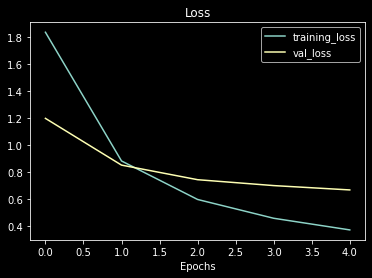

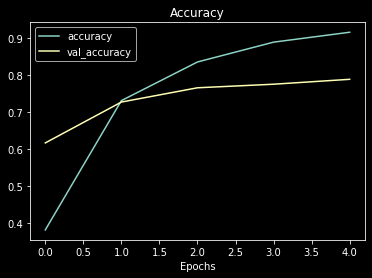

In [55]:
plot_loss_curves(history_resnet)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [56]:
# Create Efficientnet model
efficientnet_model = create_model(
    efficientnet_url, 
    train_data_10_percent.num_classes
)

In [57]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [58]:
efficientnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [60]:
efficientnet_history = efficientnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[
        create_tensorboard_callback(
            dir_name="tensorflow_hub",
            experiment_name="efficientb0"
        )
    ]
)

Saving TensorBoard log files to: tensorflow_hub/efficientb0/20220623-081806
Epoch 1/5
24/24 [==============================] - 22s 786ms/step - loss: 1.9164 - accuracy: 0.4240 - val_loss: 1.3412 - val_accuracy: 0.7288
Epoch 2/5
24/24 [==============================] - 13s 560ms/step - loss: 1.0988 - accuracy: 0.7707 - val_loss: 0.8789 - val_accuracy: 0.8176
Epoch 3/5
24/24 [==============================] - 14s 594ms/step - loss: 0.7671 - accuracy: 0.8320 - val_loss: 0.7050 - val_accuracy: 0.8412
Epoch 4/5
24/24 [==============================] - 13s 562ms/step - loss: 0.6097 - accuracy: 0.8653 - val_loss: 0.6092 - val_accuracy: 0.8604
Epoch 5/5
24/24 [==============================] - 14s 600ms/step - loss: 0.5149 - accuracy: 0.8920 - val_loss: 0.5572 - val_accuracy: 0.8628


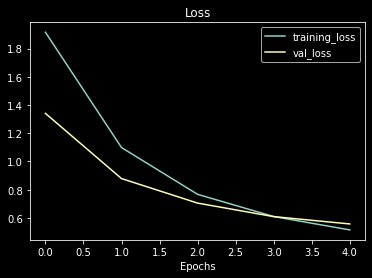

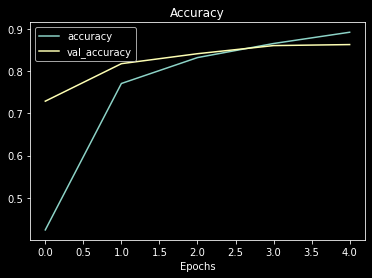

In [61]:
plot_loss_curves(efficientnet_history)

In [64]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **As is** transfer learning - using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **Feature extraction** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **Fine tuning** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)